In [1]:
import sys
import random
import time
import cv2 as cv2
import numpy as np
from datetime import datetime
from keras.models import load_model
from imutils.video import VideoStream, FPS
from shapely.geometry import Point, Polygon
import pandas as pd
import matplotlib.pyplot as plt
import imutils

#path_model = '/home/deeplearningcv/Ludis/Repo/Ludis/Squash/03 - Player Detection/'
path_model = 'C:/Repo/Ludis/Squash/03 - Player Detection/'
sys.path.insert(0, path_model)
import YOLOv3 as yolo3

Using TensorFlow backend.
C:\Users\fabri\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\fabri\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\fabri\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\fabri\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

### Definicion Paths

In [10]:
root = 'C:/GoogleDrive/'
path_court = root + 'LudisAI/05 - Court Mapping/'
path_dataset = root + 'LudisAI/00 - Datasets/'

### Instanciar el modelo y parametros

In [6]:
yolo_model = load_model(root + '/LudisAI/03 - Player Detection and Tracking/' + 'yolo_model.h5')

net_h, net_w = 416, 416
obj_thresh, nms_thresh = 0.5, 0.45
anchors = [[116,90,  156,198,  373,326],  [30,61, 62,45,  59,119], [10,13,  16,30,  33,23]]
labels = ["person"]

C:\Users\fabri\Anaconda3\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


### Definicion de coordenadas de la cancha

In [5]:
## Definicion de Coordenadas Court e Image

src_pts = np.array([
        [275,310],    # Drop izquierdo
        [215,420],    # Cuadrado de saque izquierdo superior
        [154,536],    # Fondo izquierdo
        [478,536],    # Puerta
        [802,536],    # Fondo derecho
        [748,419],    # Cuadrado de saque derecho superior 
        [700,310]     # Drop derecho
    ])

# Four corners of the court + mid-court circle point in destination image 
# Start top-left corner and go anti-clock wise + mid-court circle point
dst_pts = np.array([
      [1,  1],      # Drop izquierdo
      [1,  349],    # Cuadrado de saque izquierdo superior
      [1,  654],    # Fondo izquierdo
      [209,  654],  # Puerta
      [412, 654],   # Fondo derecho
      [412, 349],   # Cuadrado de saque derecho superior 
      [412, 1]      # Drop derecho
    ]) 

### Definicion Helpers

In [8]:
# Use the boxes info from the tensor prediction result
#
# x1,y1 ------
# |          |
# |          |
# |          |
# --------x2,y2
#

def drawPlayers(im, pred_boxes, pred_classes, showResult=False):
    
    color = [255, 0, 0]
    thickness = 3
    radius = 3

    i  = 0
    for box in pred_boxes:

        # Include only class Person
        #if pred_classes[i] == 'Person':  

        x1 = int(box.xmin)
        y1 = int(box.ymin)
        x2 = int(box.xmax)
        y2 = int(box.ymax)

        xc = x1 + int((x2 - x1)/2)
        player_pos = (xc - 1, y2 - 25)

        court = Polygon(src_pts)

        # Draw only players that are within the court
        if (box.classes[0] > obj_thresh) & (Point(player_pos).within(court)):
            if showResult:
                print("[% 3d, % 3d]" %(xc, y2))

            cv2.circle(im, player_pos, radius, color, thickness)
            i = i + 1            

    if showResult:
        cv2.imshow('Court', im)
        #cv2.imshow('Court', im_poly)
        
        k = cv2.waitKey(0)
        if k == 27:
            cv2.destroyAllWindows()

def homographyTransform(img_src, img_dst, showResult=False):

    # Calculate Homography
    h, status = cv2.findHomography(src_pts, dst_pts)
    img_out = cv2.warpPerspective(img_src, h, (img_dst.shape[1], img_dst.shape[0]))

    if showResult:
        cv2.imshow('Court', img_out)
        
        k = cv2.waitKey(0)
        if k == 27:
            cv2.destroyAllWindows()

    return img_out

def getPlayersMask(im):
    lower_range = np.array([255,0,0])                         # Set the Lower range value of blue in BGR
    upper_range = np.array([255,155,155])                     # Set the Upper range value of blue in BGR
    mask = cv2.inRange(im, lower_range, upper_range)     # Create a mask with range
    result = cv2.bitwise_and(im, im, mask = mask)   # Performing bitwise and operation with mask in img variable
    # cv2_imshow(result)                              

    return cv2.inRange(result, lower_range, upper_range)  

def drawPlayersOnCourt(im, coord, color, radius=10):
    for pos in coord:
        center_coordinates = (pos[0], pos[1])
        cv2.circle(im, center_coordinates, radius, color, thickness=-1) 

    return im

### Image Court Mapping

#### Court

In [11]:
## Court
img_court = cv2.imread(path_court + 'squash_court.jpg')
cv2.imshow('Court', img_court)

k = cv2.waitKey(0)
if k == 27:
    cv2.destroyAllWindows()

In [ ]:
#cv2.polylines(img_court, [dst_pts], isClosed=True, color=[255,0,0], thickness=2)
#cv2.imshow('Court', img_court)

#k = cv2.waitKey(0)
#if k == 27:
#    cv2.destroyAllWindows()

#### Image

In [13]:
## Image
cap = cv2.VideoCapture(path_dataset + 'test_videos/squash-trim.avi')

cap.set(1, 1050)

ret, frame = cap.read()

scale_percent = 50 # percent of original size
width = int(frame.shape[1] * scale_percent / 100)
height = int(frame.shape[0] * scale_percent / 100)
dim = (width, height) 

#image = cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)
cv2.imshow('Court', frame)

k = cv2.waitKey(0)
if k == 27:
    cv2.destroyAllWindows()

In [ ]:
# Four corners of the 3D court 
# Start top-left corner and go anti-clock wise 

im_poly = image.copy()

# cv2.fillPoly(img_src, [src_pts], 255)
cv2.polylines(im_poly, [src_pts], isClosed=True, color=[0,255,255], thickness=2)

cv2.imshow('Court', im_poly)

k = cv2.waitKey(0)
if k == 27:
    cv2.destroyAllWindows()

#### Modelo

In [ ]:
image_h, image_w, _ = image.shape
new_image = yolo3.preprocess_input(image, net_h, net_w)

# run the prediction
yolos = yolo_model.predict(new_image)
boxes = []

for i in range(len(yolos)):
    # decode the output of the network
    boxes += yolo3.decode_netout(yolos[i][0], anchors[i], obj_thresh, nms_thresh, net_h, net_w)
    
# correct the sizes of the bounding boxes
yolo3.correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w)

# suppress non-maximal boxes
yolo3.do_nms(boxes, nms_thresh)  

# draw bounding boxes on the image using labels
yolo3.draw_boxes(image, boxes, labels, obj_thresh) 

In [ ]:
## Show Boxes
cv2.imshow('Boxes', image)

k = cv2.waitKey(0)
if k == 27:
    cv2.destroyAllWindows()

In [ ]:
## Draw Boxes on Image
drawPlayers(image, boxes, labels, showResult=True)

In [ ]:
## Homography Transform
img_out = homographyTransform(image, img_court, True)

In [ ]:
## Players Mask
mask = getPlayersMask(img_out)    
cv2.imshow('Court', img_out)

k = cv2.waitKey(0)
if k == 27:
    cv2.destroyAllWindows()

In [ ]:
# Get the contours from the players "dots" so we can reduce the coordinates
# to the number of players on the court.
cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

color = [255, 0, 0]   

if cnts is not None:      
    for cnt in cnts:
        result = drawPlayersOnCourt(img_court, cnt[0], color)

cv2.imshow('Court', result)

k = cv2.waitKey(0)
if k == 27:
    cv2.destroyAllWindows()

### Video Court Mapping

In [12]:
video_input  = path_dataset + "video_test/squash-trim.avi"
video_output = path_dataset + 'video_test/squash-trim-mapping.avi'

In [14]:
from datetime import datetime
import progressbar
from time import sleep
from collections import deque
import imutils

cap = cv2.VideoCapture(video_input)

video_FourCC = int(cap.get(cv2.CAP_PROP_FOURCC))
video_fps    = int(cap.get(cv2.CAP_PROP_FPS))
totalFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
video_duration = totalFrames / video_fps

currentFrame = 0
start_time = datetime.now()
writer = None
grabbed = True
#deciles = [int(x) for x in np.linspace(0,1,11)*totalFrames]

bar = progressbar.ProgressBar(maxval=totalFrames, \
      widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

bar.start()

court_img = cv2.imread(path_court + 'squash_court.jpg')

blue_color = (255,0,0)
red_color = (0,0,255)

coords = []

# loop over frames from the video file stream (207)
while grabbed:     
  
    # read the next frame from the file
    grabbed, frame = cap.read()

    if writer is None:
        writer = cv2.VideoWriter(video_output, video_FourCC, video_fps, 
                                 (court_img.shape[1], court_img.shape[0]), True)

    if grabbed:
        
####### Reescalo el frame porque las coords de la cancha en el video estan en esta escala
        scale_percent = 50 # percent of original size
        width = int(frame.shape[1] * scale_percent / 100)
        height = int(frame.shape[0] * scale_percent / 100)
        dim = (width, height) 

        frame = cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)

####### Get player positions
        frame_h, frame_w, _ = frame.shape
        new_frame = yolo3.preprocess_input(frame, net_h, net_w)

        # run the prediction
        yolos = yolo_model.predict(new_frame)
        boxes = []

        for i in range(len(yolos)):
            # decode the output of the network
            boxes += yolo3.decode_netout(yolos[i][0], anchors[i], obj_thresh, nms_thresh, net_h, net_w)

        # correct the sizes of the bounding boxes
        yolo3.correct_yolo_boxes(boxes, frame_h, frame_w, net_h, net_w)

        # suppress non-maximal boxes
        yolo3.do_nms(boxes, nms_thresh)  

        # draw bounding boxes on the image using labels
        yolo3.draw_boxes(frame, boxes, labels, obj_thresh) 

####### Upload court
        court = court_img.copy()

####### Draw players on video frame
        drawPlayers(frame, boxes, labels, False)

        frame_out = homographyTransform(frame, court, False)
        # cv2_imshow(img_out)

        mask = getPlayersMask(frame_out)

        # cv2_imshow(mask)

        # Get the contours from the players "dots" so we can reduce the coordinates
        # to the number of players on the court.
        cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)

        if cnts is not None:      
            for cnt in cnts:
                result = drawPlayersOnCourt(court, cnt[0], blue_color)
                coords.append(cnt[0])

        writer.write(result)

        currentFrame += 1
        bar.update(currentFrame)

    else:
        grabbed = False
            

# cv2_imshow(result)
    
writer.release()
cap.release()
bar.finish()

pd.DataFrame(np.squeeze(coords), columns = ['pos_x', 'pos_y']).to_csv(path_dataset + 'squash-trim-coords.csv', 
                                                                      sep='|', decimal='.')

duration = datetime.now()-start_time
print("[INFO] process took {} seconds".format(duration))

print("Video created")

[INFO] process took 4:46:42.681617 seconds
Video created


In [15]:
ids = pd.read_csv(path_dataset + 'squash-trim-coords.csv', sep='|', decimal='.')
del ids['Unnamed: 0']

In [32]:
def create_heatmap(df, video_duration, bins=25):
    
    ## Distance and Speed calculation
    pix2meter = 0.0002645833
    df_dist = df.diff(periods=1).dropna().copy()
    df_dist['dist'] = np.sqrt(df_dist['pos_x'] ** 2 + df_dist['pos_y'] ** 2)
    distTraveled = int(np.sum(df_dist['dist']) * pix2meter)
    speed = np.round((distTraveled / video_duration) * 3600/1000, 1)
    
    
    ## Heatmap plot
    court = cv2.imread(path_court + 'squash_court.jpg')

    heatmap, xedges, yedges = np.histogram2d(df['pos_x'], df['pos_y'], bins=bins,normed=True)
    extent = [0, court.shape[1], court.shape[0], 0]
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.set_xlim(0, court.shape[1])
    ax.set_ylim(court.shape[0], 0)
    
    im1 = ax.imshow(court[:,:,[2,1,0]])

    im2 = ax.imshow(heatmap.T, cmap='hot_r', alpha=0.8, interpolation='gaussian', 
              extent=[xedges.min(), xedges.max(), yedges.max(), yedges.min()])

    plt.axis('off')
    #plt.title(f'Heatmap: Player {idx}',fontsize=15)
    plt.title(f'Heatmap: Matthew',fontsize=15)
    plt.annotate(f'Court Coverage: {distTraveled} meters',(.19,.1),xycoords='figure fraction',fontsize=12)
    plt.annotate(f'Speed: {speed} km/h',(.19,.08),xycoords='figure fraction',fontsize=12)
    plt.show()

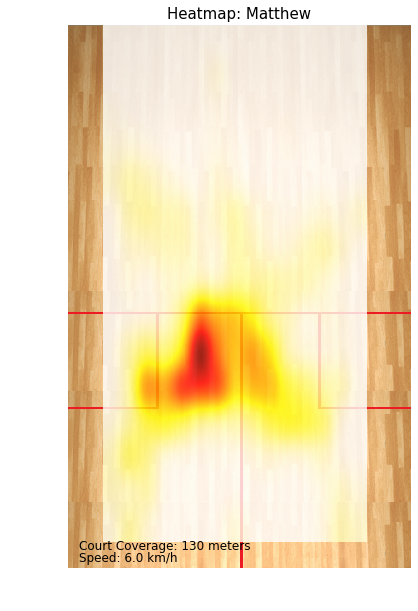

In [33]:
create_heatmap(ids, video_duration, bins=15)

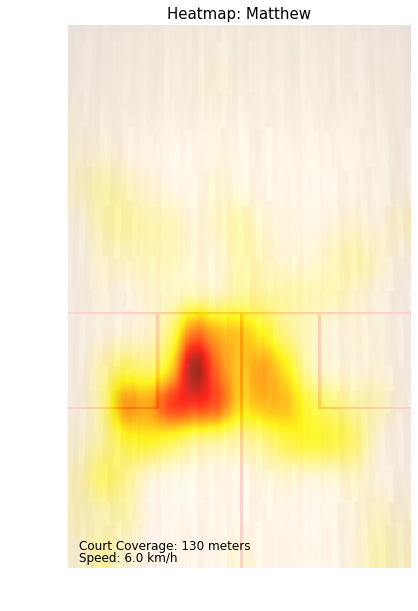

In [31]:
create_heatmap(ids, video_duration, bins=15)